In [197]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
import tensorflow as tf
import tensorflow.keras
import datetime
import numpy as np
#from tensorflow.python.keras import layers
#from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#from keras.applications.resnet import ResNet50, ResNet101, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101


from keras.layers import TimeDistributed, Conv3D, Input, Flatten, Dense, Reshape
from keras.layers import Lambda

from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#References
#Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning


Using TensorFlow backend.


In [2]:
DATASET_PATH  = '/project/sds-capstone-aaai/met/DATA/Pytorch'
# data 
IMAGE_SIZE    = (224, 224)
#Note that the default input image size for this model is 299x299, instead of 224x224 as in the VGG16 and ResNet models.

NUM_CLASSES   = 23
#
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory

FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 25 
# epoch 
WEIGHTS_FINAL = 'resnet101_25epochs.h5'
# pretrained weights from image net - but the model will use the final weights 
INP = Input(shape=(None, 224, 224, 3))

In [3]:
# data pre-processing 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   validation_split=0.3,
                                   fill_mode='nearest')

In [4]:
# 
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  subset='training',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

Found 61131 images belonging to 23 classes.


In [5]:
valid_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 26184 images belonging to 23 classes.


In [6]:
# don't need to augment validation data 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [7]:
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 9711 images belonging to 23 classes.


In [8]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = architecture
Class #1 = birds
Class #2 = boats
Class #3 = books
Class #4 = bottles
Class #5 = bowls
Class #6 = buildings
Class #7 = dogs
Class #8 = flowers
Class #9 = hieroglyphs
Class #10 = horses
Class #11 = houses
Class #12 = landscapes
Class #13 = leaves
Class #14 = lions
Class #15 = men
Class #16 = ornament
Class #17 = sculpture
Class #18 = seals
Class #19 = soldiers
Class #20 = trees
Class #21 = vases
Class #22 = women
****************


In [9]:
resnet101_imagenet_model = ResNet101(include_top=False, 
                                   weights='imagenet', 
                                   input_shape=(224, 224, 3))

# freeze the layers
for layer in resnet101_imagenet_model.layers:
    layer.trainable = False

#Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet101_imagenet_model.output)

#Fully connected layer 1
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(23, activation='softmax', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=resnet101_imagenet_model.input, outputs=fc2)

    
# set optimizer = ADAM 
# set loss criterion and metrics 

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Top 1 Accuracy 0.803


#Top 5 Accuracy 0.953
#Now, in the case of top-1 score, you check if the top class (the one having the highest probability) is the same as the target label.

#In the case of top-5 score, you check if the target label is one of your top 5 predictions (the 5 ones with the highest probabilities).

#In both cases, the top score is computed as the times a predicted label matched the target label, divided by the number of data-points evaluated.

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#%%capture cap --no-stderr
# beging training the model

model.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# save trained weights
model.save(WEIGHTS_FINAL)







#with open('output.txt', 'w') as f:
    #f.write(cap.stdout)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2728 steps, validate for 303 steps
Epoch 1/25
2728/2728 [==============================] - 5423s 2s/step - loss: 2.0556 - accuracy: 0.3788 - val_loss: 2.9084 - val_accuracy: 0.2095
Epoch 2/25
2480/2728 [==========================>...] - ETA: 7:35 - loss: 1.7995 - accuracy: 0.4407

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

In [11]:
model.load_weights('resnet101_25epochs.h5')

In [13]:
import numpy
import pandas as pd
test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)

predictions = model.predict_generator(test_batches, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys()) 

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
report = classification_report(true_classes, predicted_classes, target_names=class_labels,output_dict=True)


df = pd.DataFrame(report).transpose()
#df.to_csv('classification_report_resnet101.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
predicted_classes

array([13, 13, 20, ..., 13, 13, 13])

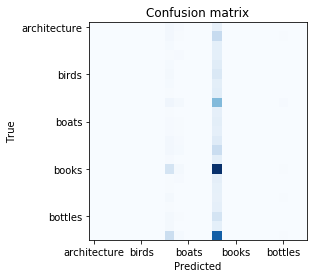

In [29]:
import matplotlib.pyplot as plt
#import seaborn as sns
labels = class_labels
cm = confusion_matrix(true_classes, predicted_classes)
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('confusion_resnet101.jpg')